In [2]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np



from MnistNet import MnistNet

In [3]:
NUM_EPOCHS = 6
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# print the seed value
# seed = torch.initial_seed()
# print('Used seed : {}'.format(seed))

In [5]:
mnistnet = MnistNet(num_classes=NUM_CLASSES).to(device)
mnistnet = torch.nn.parallel.DataParallel(mnistnet, device_ids=DEVICE_IDS)
print(mnistnet)
print('MnistNet created')

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [6]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)

(70000, 784)
(70000, 1, 28, 28)


In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

In [9]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [10]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current

In [11]:
# create optimizer
# the one that WORKS
optimizer = optim.Adam(params=mnistnet.parameters(), lr=0.0001)
### BELOW is the setting proposed by the original paper - which doesn't train....
# optimizer = optim.SGD(
#     params=alexnet.parameters(),
#     lr=LR_INIT,
#     momentum=MOMENTUM,
#     weight_decay=LR_DECAY)
print('Optimizer created')

Optimizer created


In [12]:
# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

# start training!!
print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in train_loader:
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = mnistnet(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 200 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))



        if total_steps % 400 == 0:
            a, l = evaluate_model(mnistnet)
            accuracy_train_stat.append(epoch_tr_accuracy)
            accuracy_test_stat.append(a)

            loss_train_stat.append(epoch_tr_loss)
            loss_test_stat.append(l)
        total_steps += 1


LR Scheduler created
Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Step: 200 	Loss: 0.2768 	Acc: 0.9375
Epoch: 1 	Step: 400 	Loss: 0.1902 	Acc: 0.9609375
Epoch: 2 	Step: 600 	Loss: 0.2005 	Acc: 0.96875
Epoch: 2 	Step: 800 	Loss: 0.1081 	Acc: 0.9765625
Epoch: 3 	Step: 1000 	Loss: 0.0307 	Acc: 0.984375
Epoch: 3 	Step: 1200 	Loss: 0.0375 	Acc: 0.9921875
Epoch: 3 	Step: 1400 	Loss: 0.0244 	Acc: 0.9921875
Epoch: 4 	Step: 1600 	Loss: 0.0799 	Acc: 0.9765625
Epoch: 4 	Step: 1800 	Loss: 0.0253 	Acc: 0.9921875
Epoch: 5 	Step: 2000 	Loss: 0.0038 	Acc: 1.0
Epoch: 5 	Step: 2200 	Loss: 0.0420 	Acc: 0.984375
Epoch: 6 	Step: 2400 	Loss: 0.0255 	Acc: 0.984375
Epoch: 6 	Step: 2600 	Loss: 0.0205 	Acc: 0.984375
Epoch: 6 	Step: 2800 	Loss: 0.0297 	Acc: 0.9921875


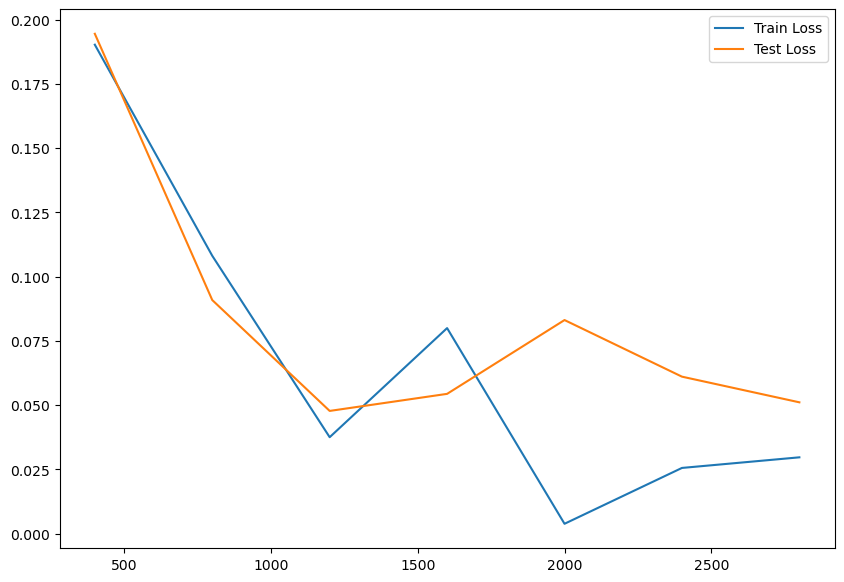

In [13]:
epochs = np.multiply(range(1, len(loss_train_stat)+1), 400)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.9308894230769231, 0.973457532051282, 0.9811698717948718, 0.9799679487179487, 0.9820713141025641, 0.9859775641025641, 0.9873798076923077]


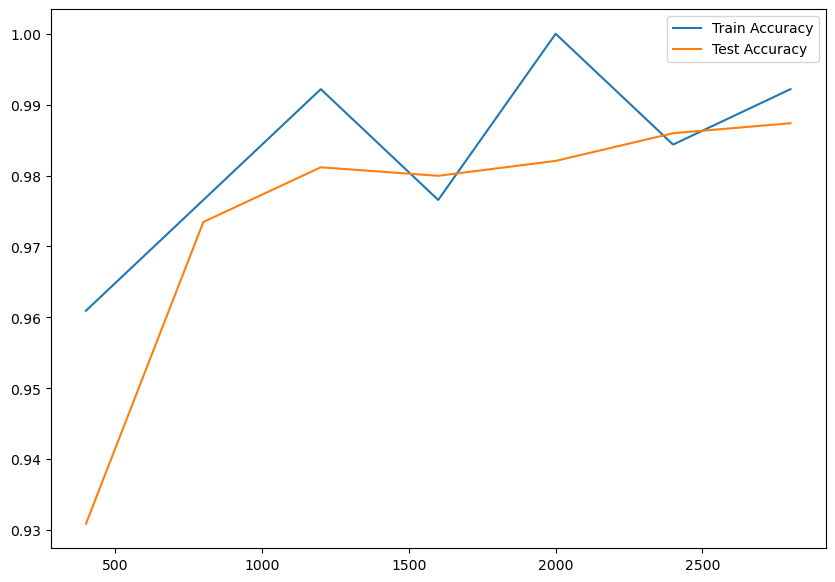

In [14]:
epochs = np.multiply(range(1, len(loss_train_stat)+1), 400)
plt.figure(figsize=(10, 7))
print(accuracy_test_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [15]:
import cv2
import numpy as np

data = []
classes = [2, 3, 6, 8, 9, 1, 0, 4, 7, 5]
for i in range(10):
    img = cv2.imread("../my_dataset/"+str(i+1)+".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sharp_filter = np.array([[-1, 0, -1],
                             [ 0, 7,  0],
                             [-1, 0, -1]])
    img = cv2.filter2D(img, ddepth=-1, kernel=sharp_filter)

    img = cv2.bitwise_not(img)
    img = img.astype('float32')
    data.append(img)

data = np.reshape(data,(len(data), 1, 28, 28))
# data = np.array(data)
classes = np.array(classes)

print(data.shape)

(10, 1, 28, 28)


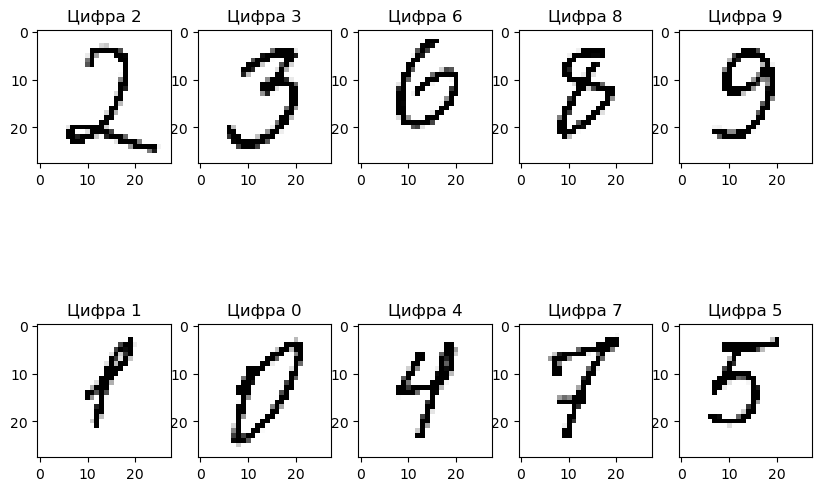

In [16]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % classes[i])

In [17]:
experiment_dataset = TensorDataset(torch.from_numpy(data).float(),
                                   torch.from_numpy(classes).long())

experiment_loader = DataLoader(experiment_dataset,
                                shuffle=False,
                                batch_size=BATCH_SIZE)

mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in experiment_loader:
        outputs = mnistnet(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")


Test accuracy: 90.0 %


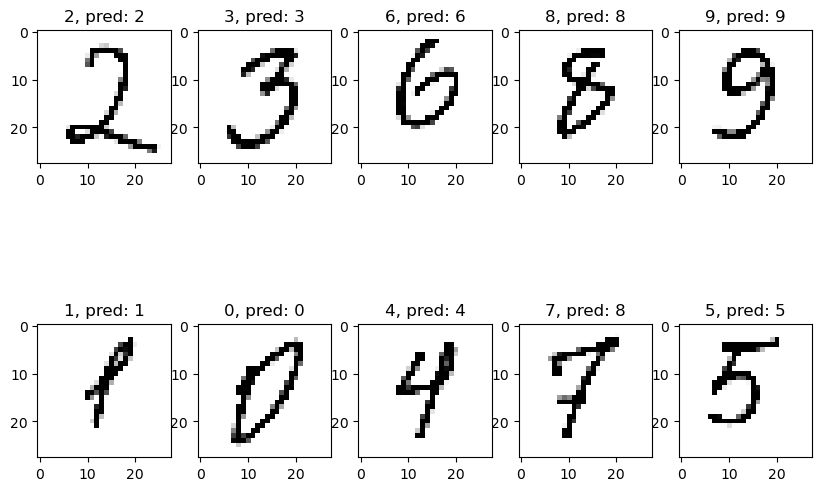

In [18]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (classes[i], predicted[i]))

In [19]:
import random
X_test_pixel = []
y_test_pixel = y_test
for i, img in enumerate(X_test):
    x = int(7 + random.random() * 14)
    y = int(7 + random.random() * 14)
    img[0][y][x] = 255

    X_test_pixel.append(img)

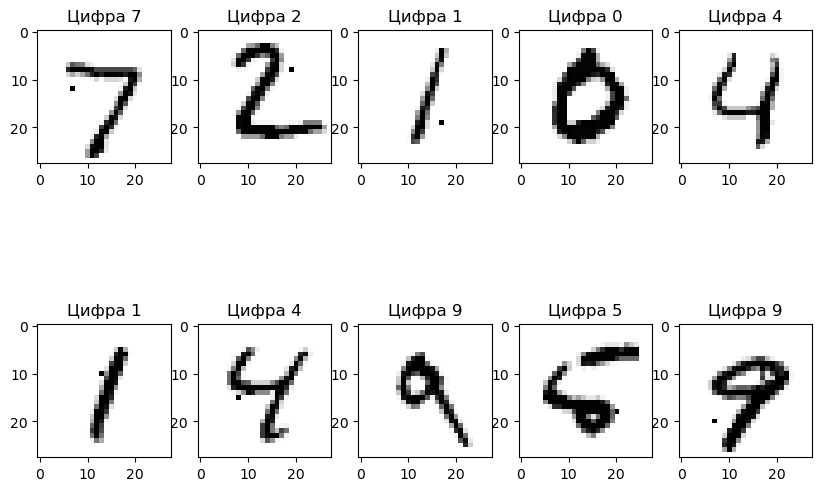

In [20]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % y_test_pixel[i])

In [21]:
X_test_pixel = np.reshape(X_test_pixel,(len(X_test_pixel), 1, 28, 28))
# data = np.array(data)
y_test_pixel = np.array(y_test_pixel)

In [22]:
pixel_dataset = TensorDataset(torch.from_numpy(X_test_pixel).float(),
                             torch.from_numpy(y_test_pixel).long())
pixel_loader = DataLoader(pixel_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,
                          batch_size=BATCH_SIZE)

In [23]:
mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predict_results = []
    for images, labels in pixel_loader:
        outputs = mnistnet(images)
        predicted_pixel = torch.argmax(outputs, dim=1)
        predict_results+=predicted_pixel
        total += labels.shape[0]
        correct += (predicted_pixel == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")

Test accuracy: 98.7 %


10000


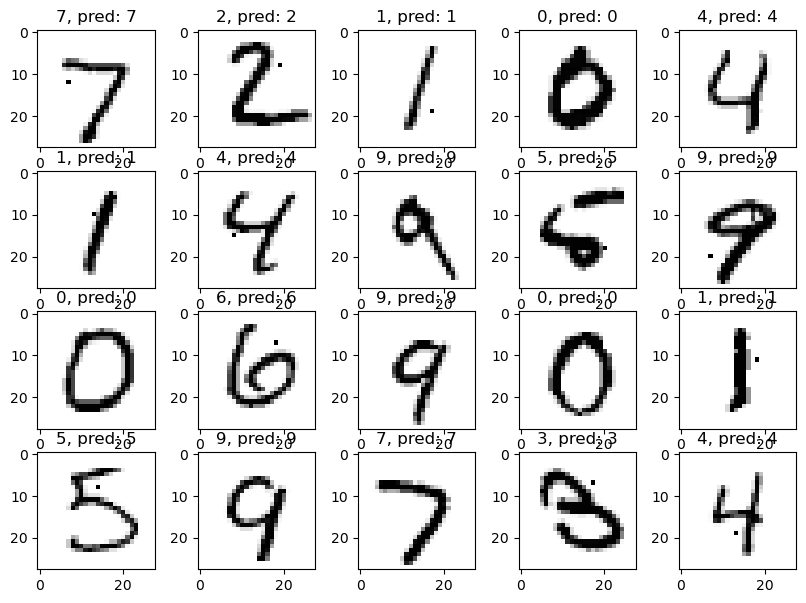

In [24]:
plt.figure(figsize=(10, 7))
print(len(predict_results))
for i in range(0, 20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test_pixel[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (y_test_pixel[i], predict_results[i]))

In [25]:
torch.save(mnistnet, 'mnistnet.pkl')

In [26]:
mdl = torch.load('mnistnet.pkl')
mdl

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [27]:
for images, labels in test_loader:
        outputs = mdl(images)
        predicted = torch.argmax(outputs, dim=1)

        print((predicted == labels).sum().item() / len(labels))

1.0
0.9921875
0.984375
0.9765625
1.0
0.9765625
0.984375
0.9921875
0.9921875
0.984375
1.0
1.0
0.984375
0.9609375
0.9921875
0.9921875
0.9765625
0.984375
0.9921875
0.984375
0.9921875
0.9921875
0.9921875
0.953125
0.9921875
0.9921875
1.0
0.984375
0.984375
0.984375
0.9921875
1.0
0.96875
0.984375
0.9921875
0.9921875
0.9765625
0.9765625
0.984375
0.984375
0.984375
0.9921875
0.9921875
0.9921875
1.0
1.0
0.9921875
0.984375
0.9765625
0.9765625
0.9921875
0.9921875
0.9921875
0.984375
0.9921875
0.9765625
0.984375
0.9921875
0.984375
0.9765625
0.984375
0.9765625
1.0
0.984375
0.9921875
0.9921875
0.984375
0.96875
1.0
1.0
0.9921875
0.984375
0.984375
1.0
0.9921875
0.984375
0.984375
0.9765625
